## Libraries

In [1]:
from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import pandas as pd

## VAE Architecture

In [63]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=200, z_dim=4):
        super().__init__()
        # encoding
        self.img2hidden = nn.Linear(input_dim, hidden_dim)
        self.hidden2hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, z_dim)
        self.hidden2sigma = nn.Linear(hidden_dim, z_dim)

        # decoder
        self.z2hidden = nn.Linear(z_dim, hidden_dim)
        self.hidden2image = nn.Linear(hidden_dim, input_dim)

        # define ReLU
        self.relu = nn.ReLU()

    def encoder(self, x):
        h = self.relu(self.img2hidden(x))
        h = self.relu(self.hidden2hidden(h))
        mu = self.hidden2mu(h)
        logvar = self.hidden2sigma(h)
        return mu, logvar

    def decoder(self, z):
        h = self.relu(self.z2hidden(z))
        h = self.relu(self.hidden2hidden(h))
        img = self.hidden2image(h)
        img = torch.sigmoid(img)
        return img


    def forward(self, x):
        mu, logvar = self.encoder(x)
        sigma = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(sigma)
        z_reparameterized = mu + sigma * epsilon

        x_reconstructed = self.decoder(z_reparameterized)

        return x_reconstructed, mu, logvar




## Train

In [102]:
device = torch.device("cpu")
input_dim = 784
hidden_dim = 200
z_dim = 4
num_epochs = 60
batch_size = 128
karpathy_constant = 3e-4



dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
random_indices = np.random.choice(len(dataset), size=5000, replace=False)
subset_train_dataset = Subset(dataset, random_indices)

train_loader = DataLoader(
    dataset=subset_train_dataset,batch_size=batch_size,shuffle = True
    )

model = VariationalAutoEncoder(input_dim=input_dim,
                               hidden_dim=hidden_dim,
                               z_dim=z_dim)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = karpathy_constant)
loss_fn = nn.BCELoss(reduction='sum')
#loss_fn = nn.BCEWithLogitsLoss(reduction='sum')


for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))

    epoch_loss = 0

    # not using labels for now
    for i, (x, _) in loop:
        x = x.to(device).view(x.shape[0], input_dim)

        x_reconstructed, mu, logvar = model(x)

        recontruction_loss = loss_fn(x_reconstructed, x)

        # kl divergence
        # minimizing the same as negative
        # pushes towards gaussian
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recontruction_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        loop.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.2f}")


# save the model
torch.save(model.state_dict(), "vae_model.pth")

100%|██████████| 40/40 [00:00<00:00, 114.39it/s, loss=3.21e+3]


Epoch [1/60], Average Loss: 492.37


100%|██████████| 40/40 [00:00<00:00, 124.15it/s, loss=3.3e+3] 


Epoch [2/60], Average Loss: 392.21


100%|██████████| 40/40 [00:00<00:00, 98.12it/s, loss=2.26e+3]


Epoch [3/60], Average Loss: 362.23


100%|██████████| 40/40 [00:00<00:00, 120.64it/s, loss=2.43e+3]


Epoch [4/60], Average Loss: 333.77


100%|██████████| 40/40 [00:00<00:00, 104.79it/s, loss=2.94e+3]


Epoch [5/60], Average Loss: 317.20


100%|██████████| 40/40 [00:00<00:00, 120.81it/s, loss=2.54e+3]


Epoch [6/60], Average Loss: 304.24


100%|██████████| 40/40 [00:00<00:00, 119.69it/s, loss=2.62e+3]


Epoch [7/60], Average Loss: 296.58


100%|██████████| 40/40 [00:00<00:00, 103.86it/s, loss=2.77e+3]


Epoch [8/60], Average Loss: 291.66


100%|██████████| 40/40 [00:00<00:00, 130.71it/s, loss=2.07e+3]


Epoch [9/60], Average Loss: 287.81


100%|██████████| 40/40 [00:00<00:00, 127.17it/s, loss=2.52e+3]


Epoch [10/60], Average Loss: 284.37


100%|██████████| 40/40 [00:00<00:00, 104.22it/s, loss=2.07e+3]


Epoch [11/60], Average Loss: 281.33


100%|██████████| 40/40 [00:00<00:00, 126.56it/s, loss=2.46e+3]


Epoch [12/60], Average Loss: 278.55


100%|██████████| 40/40 [00:00<00:00, 126.48it/s, loss=2.34e+3]


Epoch [13/60], Average Loss: 276.19


100%|██████████| 40/40 [00:00<00:00, 102.55it/s, loss=2.5e+3] 


Epoch [14/60], Average Loss: 273.58


100%|██████████| 40/40 [00:00<00:00, 127.42it/s, loss=2.17e+3]


Epoch [15/60], Average Loss: 271.57


100%|██████████| 40/40 [00:00<00:00, 123.54it/s, loss=2.16e+3]


Epoch [16/60], Average Loss: 270.02


100%|██████████| 40/40 [00:00<00:00, 99.79it/s, loss=2.16e+3] 


Epoch [17/60], Average Loss: 268.50


100%|██████████| 40/40 [00:00<00:00, 127.71it/s, loss=1.91e+3]


Epoch [18/60], Average Loss: 267.39


100%|██████████| 40/40 [00:00<00:00, 127.12it/s, loss=2.02e+3]


Epoch [19/60], Average Loss: 265.91


100%|██████████| 40/40 [00:00<00:00, 82.49it/s, loss=2.34e+3]


Epoch [20/60], Average Loss: 264.89


100%|██████████| 40/40 [00:00<00:00, 81.24it/s, loss=2.01e+3] 


Epoch [21/60], Average Loss: 263.85


100%|██████████| 40/40 [00:00<00:00, 121.66it/s, loss=2.01e+3]


Epoch [22/60], Average Loss: 262.94


100%|██████████| 40/40 [00:00<00:00, 104.30it/s, loss=2.07e+3]


Epoch [23/60], Average Loss: 262.15


100%|██████████| 40/40 [00:00<00:00, 108.75it/s, loss=2.23e+3]


Epoch [24/60], Average Loss: 261.52


100%|██████████| 40/40 [00:00<00:00, 117.67it/s, loss=2.22e+3]


Epoch [25/60], Average Loss: 260.82


100%|██████████| 40/40 [00:00<00:00, 85.77it/s, loss=1.93e+3] 


Epoch [26/60], Average Loss: 260.38


100%|██████████| 40/40 [00:00<00:00, 110.49it/s, loss=2.08e+3]


Epoch [27/60], Average Loss: 259.96


100%|██████████| 40/40 [00:00<00:00, 101.01it/s, loss=2.01e+3]


Epoch [28/60], Average Loss: 259.58


100%|██████████| 40/40 [00:00<00:00, 98.59it/s, loss=2.03e+3]


Epoch [29/60], Average Loss: 259.02


100%|██████████| 40/40 [00:00<00:00, 85.82it/s, loss=1.66e+3] 


Epoch [30/60], Average Loss: 258.66


100%|██████████| 40/40 [00:00<00:00, 111.77it/s, loss=2.46e+3]


Epoch [31/60], Average Loss: 258.36


100%|██████████| 40/40 [00:00<00:00, 114.85it/s, loss=1.88e+3]


Epoch [32/60], Average Loss: 258.09


100%|██████████| 40/40 [00:00<00:00, 124.44it/s, loss=1.66e+3]


Epoch [33/60], Average Loss: 257.86


100%|██████████| 40/40 [00:00<00:00, 126.43it/s, loss=1.89e+3]


Epoch [34/60], Average Loss: 257.50


100%|██████████| 40/40 [00:00<00:00, 126.25it/s, loss=2.1e+3] 


Epoch [35/60], Average Loss: 257.20


100%|██████████| 40/40 [00:00<00:00, 119.90it/s, loss=2.03e+3]


Epoch [36/60], Average Loss: 257.00


100%|██████████| 40/40 [00:00<00:00, 77.30it/s, loss=2.34e+3]


Epoch [37/60], Average Loss: 256.96


100%|██████████| 40/40 [00:00<00:00, 124.72it/s, loss=2.16e+3]


Epoch [38/60], Average Loss: 256.76


100%|██████████| 40/40 [00:00<00:00, 129.82it/s, loss=2.09e+3]


Epoch [39/60], Average Loss: 256.46


100%|██████████| 40/40 [00:00<00:00, 117.09it/s, loss=2.01e+3]


Epoch [40/60], Average Loss: 256.28


100%|██████████| 40/40 [00:00<00:00, 106.58it/s, loss=2.33e+3]


Epoch [41/60], Average Loss: 256.21


100%|██████████| 40/40 [00:00<00:00, 125.60it/s, loss=1.8e+3] 


Epoch [42/60], Average Loss: 255.91


100%|██████████| 40/40 [00:00<00:00, 135.68it/s, loss=1.9e+3] 


Epoch [43/60], Average Loss: 255.65


100%|██████████| 40/40 [00:00<00:00, 110.21it/s, loss=1.9e+3] 


Epoch [44/60], Average Loss: 255.51


100%|██████████| 40/40 [00:00<00:00, 135.64it/s, loss=2.13e+3]


Epoch [45/60], Average Loss: 255.37


100%|██████████| 40/40 [00:00<00:00, 136.66it/s, loss=2.29e+3]


Epoch [46/60], Average Loss: 255.07


100%|██████████| 40/40 [00:00<00:00, 134.87it/s, loss=1.99e+3]


Epoch [47/60], Average Loss: 255.04


100%|██████████| 40/40 [00:00<00:00, 110.02it/s, loss=2.33e+3]


Epoch [48/60], Average Loss: 254.82


100%|██████████| 40/40 [00:00<00:00, 136.75it/s, loss=2.02e+3]


Epoch [49/60], Average Loss: 254.71


100%|██████████| 40/40 [00:00<00:00, 137.98it/s, loss=2.07e+3]


Epoch [50/60], Average Loss: 254.47


100%|██████████| 40/40 [00:00<00:00, 138.47it/s, loss=1.81e+3]


Epoch [51/60], Average Loss: 254.33


100%|██████████| 40/40 [00:00<00:00, 108.91it/s, loss=2.08e+3]


Epoch [52/60], Average Loss: 254.23


100%|██████████| 40/40 [00:00<00:00, 137.37it/s, loss=2.21e+3]


Epoch [53/60], Average Loss: 254.08


100%|██████████| 40/40 [00:00<00:00, 137.98it/s, loss=2.25e+3]


Epoch [54/60], Average Loss: 254.11


100%|██████████| 40/40 [00:00<00:00, 108.73it/s, loss=2.23e+3]


Epoch [55/60], Average Loss: 253.82


100%|██████████| 40/40 [00:00<00:00, 137.26it/s, loss=1.73e+3]


Epoch [56/60], Average Loss: 253.58


100%|██████████| 40/40 [00:00<00:00, 140.22it/s, loss=2.01e+3]


Epoch [57/60], Average Loss: 253.55


100%|██████████| 40/40 [00:00<00:00, 111.14it/s, loss=1.73e+3]


Epoch [58/60], Average Loss: 253.37


100%|██████████| 40/40 [00:00<00:00, 134.62it/s, loss=2.14e+3]


Epoch [59/60], Average Loss: 253.50


100%|██████████| 40/40 [00:00<00:00, 138.19it/s, loss=2.06e+3]


Epoch [60/60], Average Loss: 253.26


## Inference

In [65]:
# Load the trained model
model = VariationalAutoEncoder(input_dim=input_dim, hidden_dim=hidden_dim, z_dim=z_dim).to(device)
model.load_state_dict(torch.load("vae_model.pth"))  # Make sure to save your model at training time
model.eval()

# Load MNIST test data
test_dataset = datasets.FashionMNIST(root=".data/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get one batch
test_batch = next(iter(test_loader))[0].to(device)
test_batch_flat = test_batch.view(test_batch.size(0), -1)

# Inference
with torch.no_grad():
    recon_batch, _, _ = model(test_batch_flat)

# Reshape for visualization
recon_batch = recon_batch.view(-1, 1, 28, 28)
original = test_batch.view(-1, 1, 28, 28)

# Concatenate and save
comparison = torch.cat([original, recon_batch])
save_image(comparison, "inference_reconstruction.png", nrow=8)

Create dataframe with embeddings

In [66]:

model = VariationalAutoEncoder(input_dim=input_dim, hidden_dim=hidden_dim, z_dim=z_dim).to(device)
model.load_state_dict(torch.load("vae_model.pth"))
model.eval()

VariationalAutoEncoder(
  (img2hidden): Linear(in_features=784, out_features=200, bias=True)
  (hidden2hidden): Linear(in_features=200, out_features=200, bias=True)
  (hidden2mu): Linear(in_features=200, out_features=4, bias=True)
  (hidden2sigma): Linear(in_features=200, out_features=4, bias=True)
  (z2hidden): Linear(in_features=4, out_features=200, bias=True)
  (hidden2image): Linear(in_features=200, out_features=784, bias=True)
  (relu): ReLU()
)

In [67]:
full_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transforms.ToTensor())
full_loader = DataLoader(full_dataset, batch_size=256, shuffle=False)

In [68]:
all_embeddings = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in tqdm(full_loader):
        x_batch = x_batch.view(x_batch.size(0), -1).to(device)
        mu, _ = model.encoder(x_batch)
        all_embeddings.append(mu.cpu())
        all_labels.append(y_batch)

100%|██████████| 235/235 [00:01<00:00, 121.08it/s]


In [69]:
# Concatenate all latent vectors and labels
all_embeddings = torch.cat(all_embeddings).numpy()
all_labels = torch.cat(all_labels).numpy()

In [70]:
# Save to a DataFrame
latent_df = pd.DataFrame(all_embeddings)
latent_df['label'] = all_labels

In [71]:
latent_df.shape

(60000, 5)

In [72]:
# Save to CSV
latent_df.to_csv("vae_latent_embeddings.csv", index=False)
print("Saved latent embeddings with labels.")

Saved latent embeddings with labels.


Now create some plots: T-SNE

Computes pairwise similarity between points in the high-dimensional space

Tries to preserve those similarities in a lower-dimensional space (e.g., 2D)

Optimizes a probability distribution to match the original one using Kullback-Leibler divergence

The result:

Clusters of similar points stay together

Dissimilar points move far apart

Embedding may distort global structure a bit, but shows local clusters clearly

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [74]:
# Sample 250 per class
latent_df = pd.read_csv("vae_latent_embeddings.csv")
sampled_df = latent_df.groupby("label").sample(n=600, random_state=42)
X = sampled_df.drop(columns=["label"]).values
y = sampled_df["label"].values

In [75]:
# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


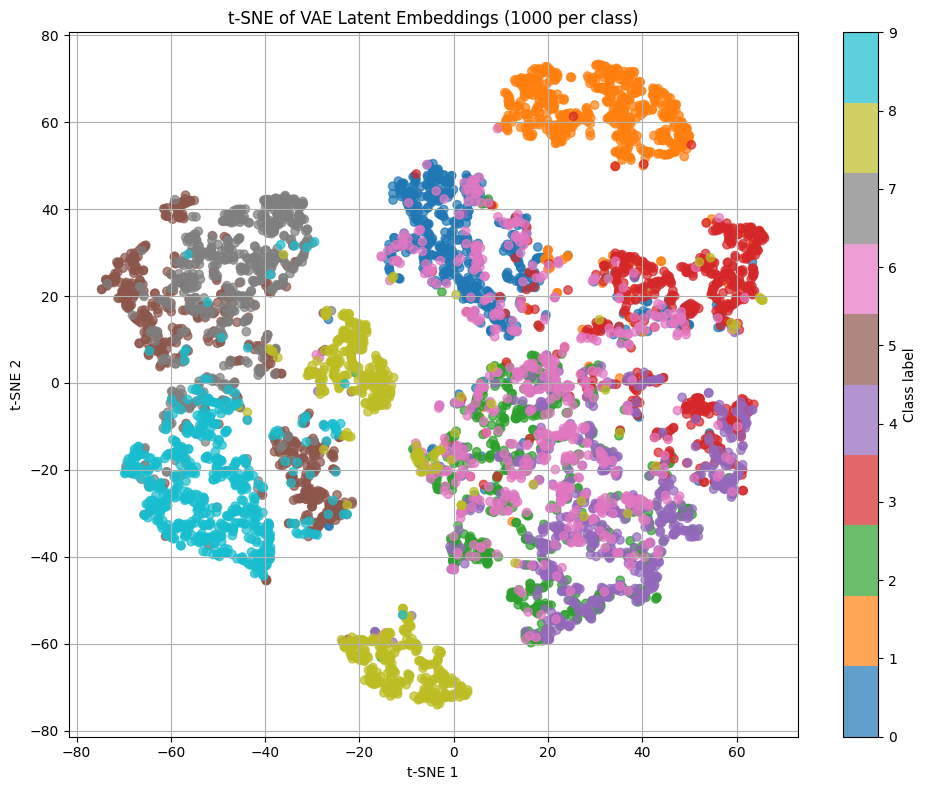

In [76]:
# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="tab10", alpha=0.7)
plt.title("t-SNE of VAE Latent Embeddings (1000 per class)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(scatter, ticks=range(10), label="Class label")
plt.grid(True)
plt.tight_layout()
plt.show()

NOW DO PCA

In [144]:
# --- Assume latent_df is already loaded ---
# Features and labels
from sklearn.decomposition import PCA

latent_df = pd.read_csv("vae_latent_embeddings.csv")

X = latent_df.drop(columns=["label"]).values
y = latent_df["label"].values

In [145]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [146]:
# Apply PCA
pca = PCA(n_components=X_scaled.shape[1])
X_pca = pca.fit_transform(X_scaled)

In [67]:
# Add PCA results to a DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_df["label"] = y

In [68]:
# Group by class and compute mean component values
mean_components_by_class = pca_df.groupby("label").mean()

In [69]:
# Print component averages per class
print("Mean value of each principal component by class:\n")
print(mean_components_by_class)

Mean value of each principal component by class:

            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
label                                                                         
0      0.575805  0.185771 -0.583486  0.168547 -0.584945  0.063932  1.255897   
1     -0.488854 -2.012672 -2.285750 -1.106646 -0.715498  0.041927  0.172629   
2     -1.745781  1.736938 -0.009238  0.277206  0.671488  0.253212  0.384857   
3     -0.236242  1.252439 -1.056971 -1.030132 -1.220551 -0.529283 -0.455649   
4     -0.929801  1.215141 -0.246564  0.928158  0.285499 -0.055515 -0.135762   
5     -0.160362 -0.683358  1.365979  0.157354 -0.311942  0.583477 -0.548108   
6     -0.650844  1.106166 -0.152049  0.731165 -0.142431  0.023482  0.469467   
7      0.490398 -1.672778  0.111622 -0.129090  1.051766  0.976744 -1.217720   
8      2.882461 -0.261960  0.584677  1.412161  0.487903 -0.514074  0.216292   
9      0.263220 -0.865687  2.271779 -1.408723  0.478711 -0.843902 -0.141903   

 

In [72]:
explained_var = np.clip(pca.explained_variance_ratio_, 0, None)

# Get PCA loadings (components_) — shape: [n_components, n_original_features]
loadings = pca.components_

# Get original feature names (from latent_df, assuming it's all latent dims)
feature_names = latent_df.drop(columns=["label"]).columns

# For each PC, extract the top 3 contributing features
top_features = []
for pc_weights in loadings:
    # Pair each weight with its feature name
    pairs = list(zip(feature_names, pc_weights))
    # Sort by absolute weight (importance), descending
    top = sorted(pairs, key=lambda x: abs(x[1]), reverse=True)[:3]
    # Format for display
    top_str = ", ".join([f"{name} ({weight:.2f})" for name, weight in top])
    top_features.append(top_str)

# Build the DataFrame
explained_variance_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(explained_var))],
    "Explained Variance Ratio": explained_var,
    "Cumulative Variance": np.cumsum(explained_var),
    "Top Contributing Features": top_features
})

explained_variance_df.head()

,Principal Component,Explained Variance Ratio,Cumulative Variance,Top Contributing Features
0,PC1,0.295929,0.295929,"12 (0.39), 11 (-0.33), 2 (0.32)"
1,PC2,0.180332,0.476261,"6 (0.43), 15 (-0.42), 7 (0.36)"
2,PC3,0.116659,0.592920,"3 (0.46), 0 (0.43), 19 (-0.37)"
3,PC4,0.109703,0.702623,"5 (0.43), 17 (0.38), 8 (-0.32)"
4,PC5,0.078051,0.780674,"13 (0.61), 10 (-0.58), 7 (-0.25)"


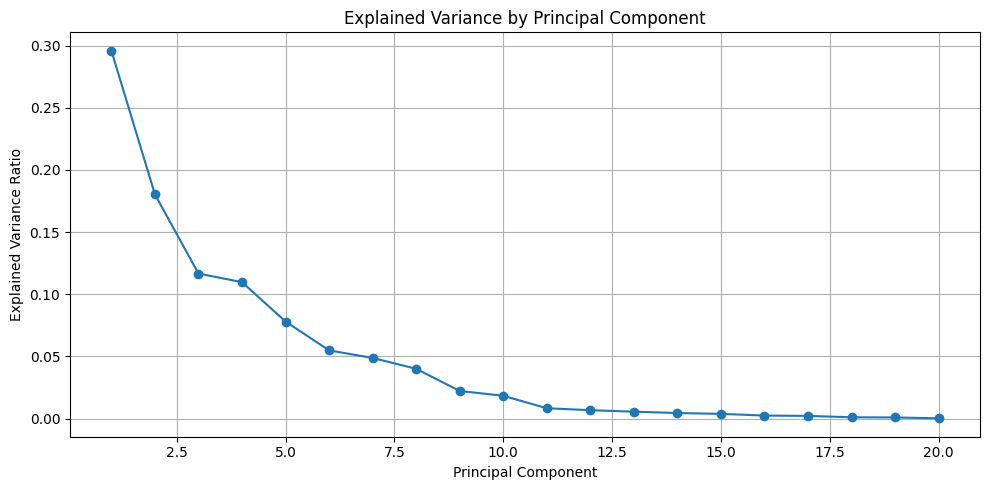

In [46]:
# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance by Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
latent_df = pd.read_csv("vae_latent_embeddings.csv")

labels = sorted(latent_df["label"].unique())
explained_variances_by_class = {}

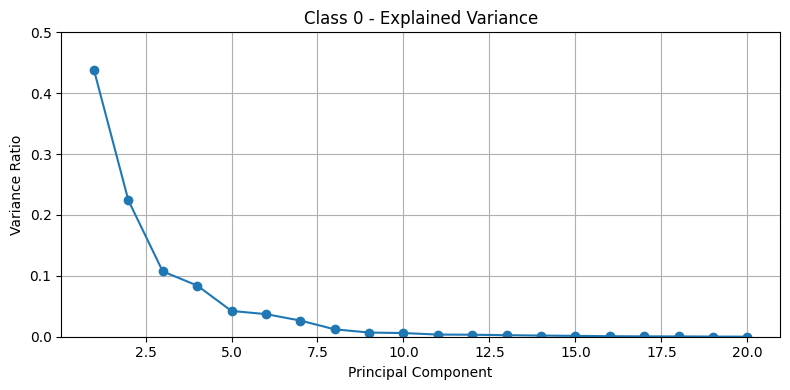

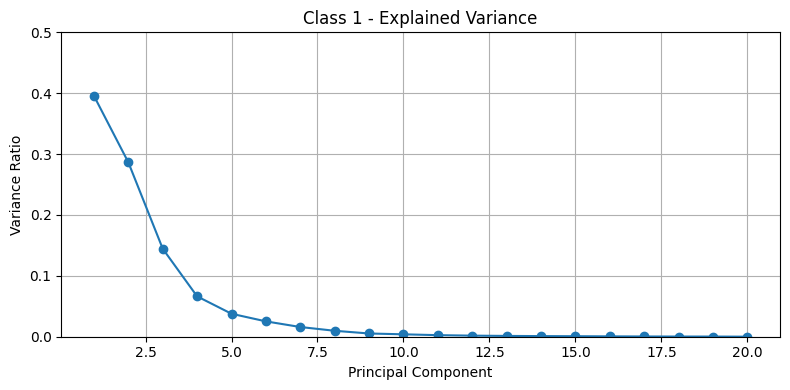

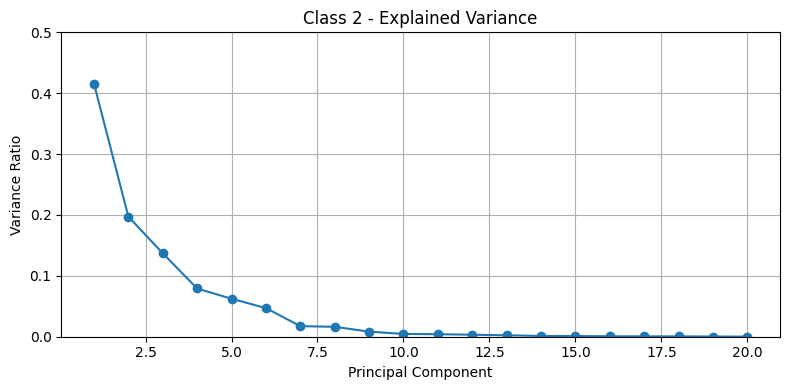

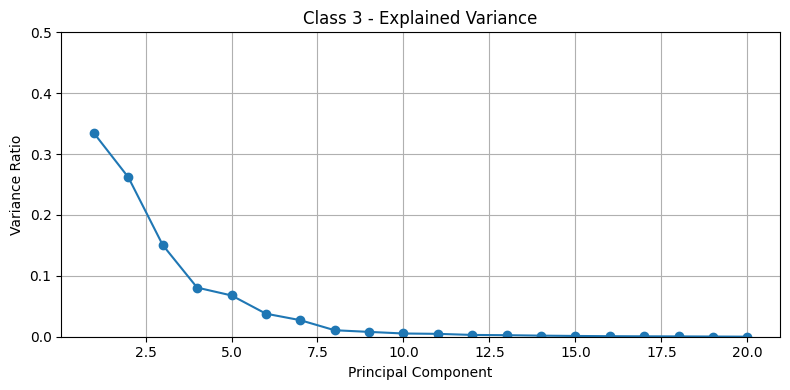

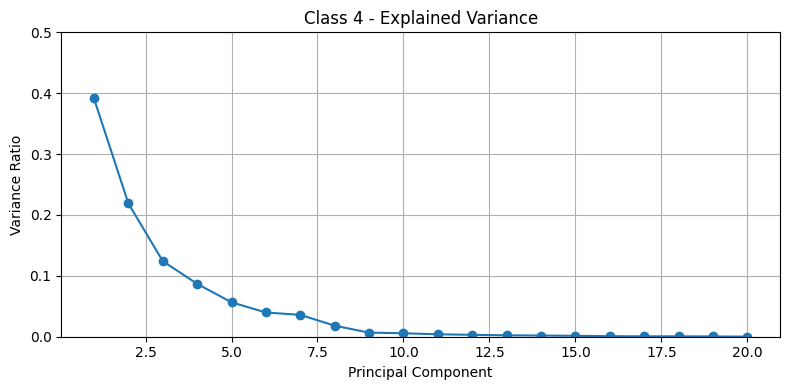

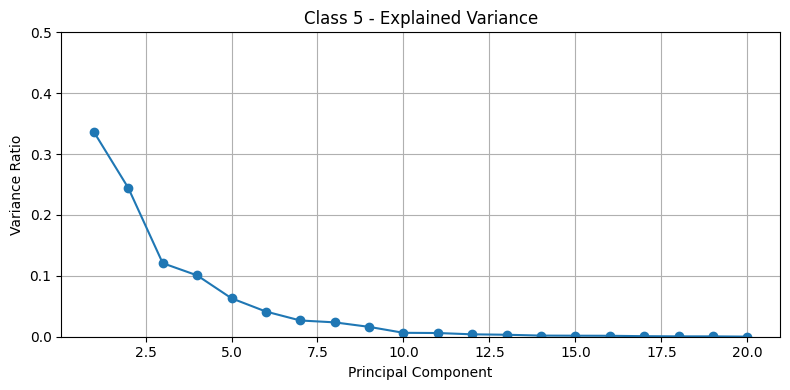

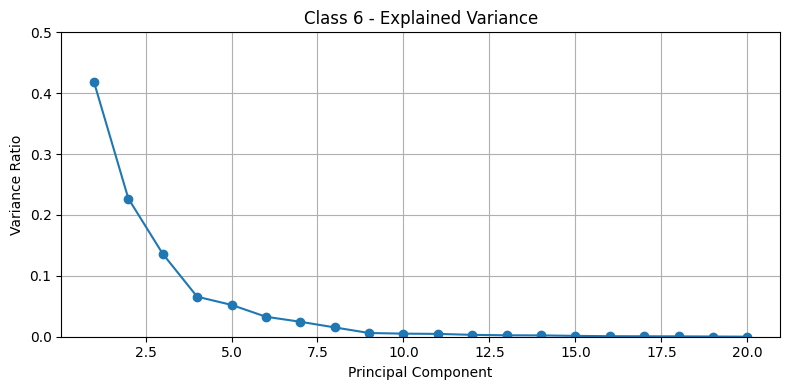

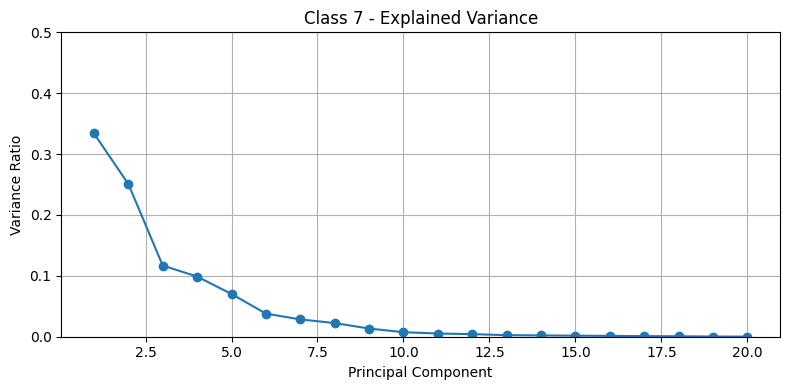

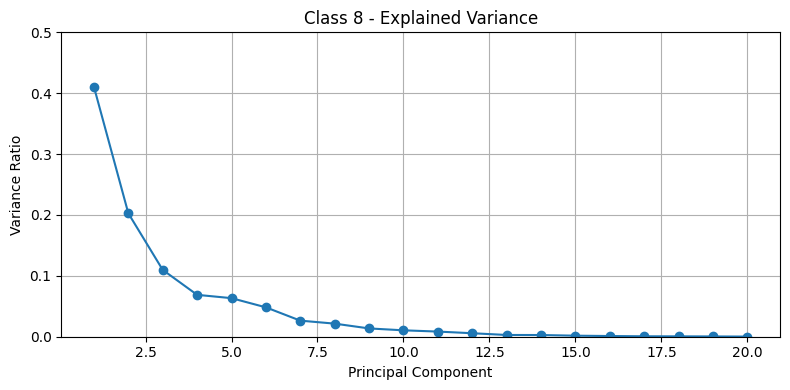

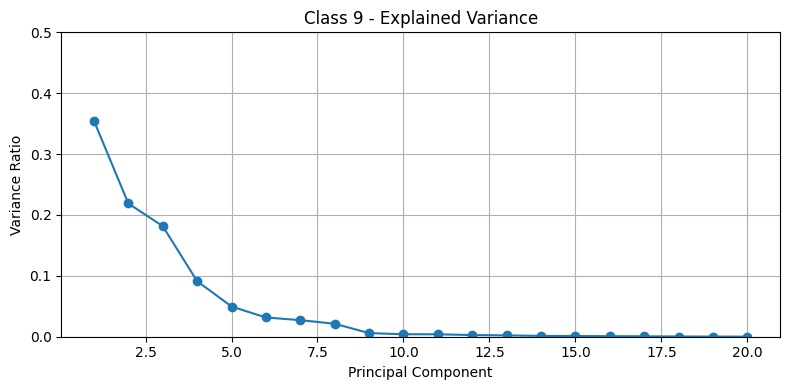

In [60]:
for label in labels:
    class_df = latent_df[latent_df["label"] == label].drop(columns=["label"])

    # Standardize
    scaler = StandardScaler()
    class_scaled = scaler.fit_transform(class_df)

    # PCA
    pca = PCA(n_components=class_scaled.shape[1])
    class_pca = pca.fit_transform(class_scaled)

    # Store explained variance ratios
    explained_variances_by_class[label] = pca.explained_variance_ratio_

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_, marker='o')
    plt.title(f"Class {label} - Explained Variance")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")
    plt.ylim(0, 0.5)  # Fix y-axis across all plots
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [62]:
import pandas as pd

# Convert explained_variances_by_class (dict) to a DataFrame
# Truncate or pad all rows to same length (e.g., 20 PCs)
max_pcs = 20  # you can adjust this
data = {}

for label, ratios in explained_variances_by_class.items():
    padded = list(ratios[:max_pcs]) + [0.0] * (max_pcs - len(ratios))
    data[label] = padded

explained_variance_df = pd.DataFrame.from_dict(data, orient='index',
                                               columns=[f'PC{i+1}' for i in range(max_pcs)])
explained_variance_df.index.name = 'Class'

# Display the DataFrame
display(explained_variance_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Class,,,,,,,,,,,,,,,,,,,,
0,0.438368,0.224201,0.107318,0.084139,0.042345,0.037145,0.026566,0.012178,0.006856,0.006024,0.003538,0.003282,0.002508,0.001880,0.001412,0.000828,0.000552,0.000500,0.000249,0.000112
1,0.395682,0.286433,0.144572,0.066300,0.037733,0.025216,0.015958,0.009759,0.005309,0.003948,0.002568,0.001765,0.001317,0.001025,0.000816,0.000591,0.000391,0.000291,0.000260,0.000063
2,0.415908,0.197375,0.137092,0.079261,0.062338,0.047082,0.017379,0.016277,0.008357,0.004559,0.004141,0.003274,0.002342,0.001238,0.001096,0.000695,0.000585,0.000558,0.000331,0.000114
3,0.334402,0.261880,0.150627,0.080699,0.067812,0.037857,0.027192,0.010645,0.007938,0.005301,0.004699,0.002944,0.002518,0.001778,0.001255,0.000882,0.000651,0.000518,0.000317,0.000088
4,0.391371,0.219083,0.124221,0.086918,0.056564,0.039792,0.035915,0.018125,0.006781,0.005676,0.003980,0.003123,0.002309,0.001938,0.001475,0.000871,0.000650,0.000628,0.000462,0.000117
5,0.336257,0.244251,0.120823,0.100775,0.063126,0.041372,0.026682,0.023594,0.016203,0.006425,0.006070,0.003924,0.003244,0.001854,0.001672,0.001538,0.000878,0.000582,0.000569,0.000160
6,0.418608,0.226992,0.136223,0.065761,0.052283,0.032831,0.024587,0.015300,0.006119,0.005052,0.004620,0.003090,0.002343,0.002171,0.001394,0.000868,0.000715,0.000604,0.000343,0.000095
7,0.333904,0.250884,0.116958,0.098873,0.070186,0.037993,0.028422,0.022441,0.013458,0.007426,0.005267,0.004233,0.002568,0.002108,0.001711,0.001381,0.001008,0.000719,0.000321,0.000138
8,0.410397,0.202694,0.109758,0.068807,0.063353,0.048259,0.026424,0.021499,0.013621,0.010516,0.008457,0.005725,0.002878,0.002780,0.001701,0.001153,0.000700,0.000602,0.000448,0.000228


In [73]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ensure 'latent_df' is already loaded and includes a 'label' column
feature_cols = latent_df.drop(columns=["label"]).columns
max_pcs = min(20, len(feature_cols))  # Limit to 20 PCs or total features

# Store results
records = []

# Iterate over each class
for label in sorted(latent_df["label"].unique()):
    class_df = latent_df[latent_df["label"] == label].drop(columns=["label"])

    # Standardize the features for this class
    scaler = StandardScaler()
    X_class_scaled = scaler.fit_transform(class_df)

    # PCA
    pca = PCA(n_components=max_pcs)
    X_pca = pca.fit_transform(X_class_scaled)

    # Get explained variance and loadings
    explained_variance = np.clip(pca.explained_variance_ratio_, 0, None)
    cumulative_variance = np.cumsum(explained_variance)
    loadings = pca.components_

    # For each PC, get top contributing features
    for pc_idx in range(max_pcs):
        pc_loadings = loadings[pc_idx]
        feature_importances = list(zip(feature_cols, pc_loadings))
        top_features = sorted(feature_importances, key=lambda x: abs(x[1]), reverse=True)[:3]
        top_feature_str = ", ".join([f"{feat} ({weight:.2f})" for feat, weight in top_features])

        # Save record
        records.append({
            "Class": label,
            "Principal Component": f"PC{pc_idx+1}",
            "Explained Variance Ratio": explained_variance[pc_idx],
            "Cumulative Variance": cumulative_variance[pc_idx],
            "Top Contributing Features": top_feature_str
        })

# Create DataFrame
classwise_pca_df = pd.DataFrame(records)

# Display the DataFrame
display(classwise_pca_df)


,Class,Principal Component,Explained Variance Ratio,Cumulative Variance,Top Contributing Features
0,0,PC1,0.438368,0.438368,"12 (0.33), 19 (0.32), 16 (0.31)"
1,0,PC2,0.224201,0.662569,"4 (0.44), 15 (-0.42), 10 (0.33)"
2,0,PC3,0.107318,0.769887,"14 (0.46), 1 (-0.39), 18 (-0.37)"
3,0,PC4,0.084139,0.854026,"3 (0.65), 13 (0.54), 5 (0.36)"
4,0,PC5,0.042345,0.896372,"0 (0.59), 10 (-0.52), 3 (-0.34)"
...,...,...,...,...,...
195,9,PC16,0.000882,0.998598,"14 (0.52), 18 (0.40), 0 (0.38)"
196,9,PC17,0.000676,0.999274,"9 (0.48), 18 (-0.38), 3 (0.38)"
197,9,PC18,0.000349,0.999623,"9 (0.60), 17 (0.50), 18 (0.40)"
198,9,PC19,0.000245,0.999868,"10 (0.55), 7 (-0.41), 19 (0.38)"


Now try CART

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn import tree

In [78]:
# 1. Load features and labels from latent_df
latent_df = pd.read_csv("vae_latent_embeddings.csv")
# Define labels to drop
##labels_to_drop = [0, 2, 3, 4, 6]

# Drop rows with those labels
#latent_df = latent_df[~latent_df["label"].isin(labels_to_drop)].reset_index(drop=True)

X = latent_df.drop(columns=["label"]).values
y = latent_df["label"].values

In [79]:
# 2. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Initialize CART model (Decision Tree)
clf = DecisionTreeClassifier(max_depth=12, random_state=42)

# 4. Train
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, random_state=42)

In [80]:
# 5. Evaluate
y_pred = clf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7504166666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1200
           1       0.95      0.91      0.93      1200
           2       0.59      0.60      0.60      1200
           3       0.74      0.79      0.76      1200
           4       0.61      0.64      0.63      1200
           5       0.79      0.79      0.79      1200
           6       0.50      0.46      0.48      1200
           7       0.80      0.76      0.78      1200
           8       0.91      0.92      0.92      1200
           9       0.84      0.87      0.85      1200

    accuracy                           0.75     12000
   macro avg       0.75      0.75      0.75     12000
weighted avg       0.75      0.75      0.75     12000



In [41]:
# 6. Feature importances (optional)
importances = clf.feature_importances_
for i, score in enumerate(importances):
    if score > 0:
        print(f"Latent dim z_{i}: importance = {score:.3f}")

# 7. Visualize tree (optional)
#plt.figure(figsize=(20, 10))
#tree.plot_tree(clf, filled=True, feature_names=[f"z_{i}" for i in range(X.shape[1])],
       #        class_names=[str(i) for i in sorted(set(y))], rounded=True)
#plt.title("CART on VAE Latent Embeddings")
#plt.show()

Latent dim z_0: importance = 0.002
Latent dim z_1: importance = 0.001
Latent dim z_2: importance = 0.001
Latent dim z_3: importance = 0.002
Latent dim z_4: importance = 0.016
Latent dim z_5: importance = 0.002
Latent dim z_6: importance = 0.003
Latent dim z_7: importance = 0.077
Latent dim z_8: importance = 0.006
Latent dim z_9: importance = 0.002
Latent dim z_10: importance = 0.001
Latent dim z_11: importance = 0.002
Latent dim z_12: importance = 0.143
Latent dim z_13: importance = 0.016
Latent dim z_14: importance = 0.021
Latent dim z_15: importance = 0.035
Latent dim z_16: importance = 0.001
Latent dim z_17: importance = 0.005
Latent dim z_18: importance = 0.006
Latent dim z_19: importance = 0.008
Latent dim z_20: importance = 0.065
Latent dim z_21: importance = 0.005
Latent dim z_22: importance = 0.005
Latent dim z_23: importance = 0.050
Latent dim z_24: importance = 0.012
Latent dim z_25: importance = 0.001
Latent dim z_26: importance = 0.003
Latent dim z_27: importance = 0.002
La

In [118]:
# Train your CART model
from collections import defaultdict



# Get the tree object
tree_ = clf.tree_

# Store: feature_id → class distribution
feature_to_class_influence = defaultdict(list)

# Walk through the tree
for node_id in range(tree_.node_count):
    feature_id = tree_.feature[node_id]

    # Skip leaf nodes (feature == _tree.TREE_UNDEFINED)
    if feature_id == -2:
        continue

    # Class distribution at this node
    class_counts = tree_.value[node_id][0]
    dominant_class = np.argmax(class_counts)
    total = class_counts.sum()

    # Track how much this node contributes to the dominant class
    feature_to_class_influence[feature_id].append((dominant_class, total))

# Summarize which class each feature helps most
summary = []
for feat_id, contributions in feature_to_class_influence.items():
    class_votes = defaultdict(float)
    for label, weight in contributions:
        class_votes[label] += weight
    # Find top class and total weight
    top_class = max(class_votes, key=class_votes.get)
    summary.append((f"z_{feat_id}", top_class, round(class_votes[top_class], 1)))

# Display results
summary = sorted(summary, key=lambda x: x[2], reverse=True)
print("Feature  | Most Influential For Class | Weighted Impact")
for feat, label, impact in summary:
    print(f"{feat:<8} | {label:<26} | {impact}")

Feature  | Most Influential For Class | Weighted Impact
z_13     | 5                          | 21.0
z_5      | 5                          | 21.0
z_10     | 5                          | 19.0
z_1      | 5                          | 16.0
z_14     | 7                          | 15.0
z_4      | 9                          | 13.0
z_17     | 5                          | 11.0
z_12     | 5                          | 11.0
z_2      | 9                          | 11.0
z_16     | 5                          | 11.0
z_18     | 3                          | 11.0
z_8      | 5                          | 11.0
z_3      | 5                          | 10.0
z_11     | 7                          | 10.0
z_19     | 5                          | 10.0
z_15     | 7                          | 10.0
z_0      | 5                          | 8.0
z_7      | 9                          | 7.0
z_9      | 5                          | 6.0
z_6      | 9                          | 6.0


Random Forest


generating samples until KL divergence is low - is it different for each model
how does using the embedding analysis inform us of how good/bad our original trained model is

In [81]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

In [82]:
latent_df = pd.read_csv("vae_latent_embeddings.csv")
label_col = 'label'
X = latent_df.drop(columns=[label_col]).values   # latent vectors
y = latent_df[label_col].values                  # integer labels 0-9

# stratified 80 / 20 split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y)

In [83]:
rf = RandomForestClassifier(
        n_estimators = 200,
        max_depth    = 10,   # or set e.g. 15 to limit over-fit
        max_features = 'sqrt',
        n_jobs       = -1,
        random_state = 42)

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [84]:
y_pred = rf.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=2))


Test Accuracy: 0.7658

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1200
           1       0.97      0.91      0.94      1200
           2       0.61      0.56      0.59      1200
           3       0.75      0.83      0.79      1200
           4       0.62      0.64      0.63      1200
           5       0.81      0.84      0.83      1200
           6       0.50      0.44      0.47      1200
           7       0.84      0.77      0.80      1200
           8       0.89      0.95      0.92      1200
           9       0.88      0.90      0.89      1200

    accuracy                           0.77     12000
   macro avg       0.76      0.77      0.76     12000
weighted avg       0.76      0.77      0.76     12000



In [85]:
import numpy as np
import torch
from sklearn.tree import DecisionTreeClassifier

# ---------------------------------------------------------------------
# 1.  Inspect the fitted tree and pull out leaf-level information
# ---------------------------------------------------------------------
def collect_leaf_stats(tree: DecisionTreeClassifier,
                       Z: np.ndarray,
                       y: np.ndarray,
                       target_label: int,
                       purity_thr: float = 0.80):
    """
    Returns a list of dictionaries, one per leaf whose *majority* class
    is `target_label` and whose purity ≥ `purity_thr`.

    Each dict contains:
      - 'idx':    indices of points in the leaf
      - 'support','purity'
      - 'bounds': (lo, hi) arrays of shape (z_dim,)
      - 'centroid': mean of *target_label* points only
      - 'cov': diagonal covariance of those points (for jitter)
    """
    leaf_id   = tree.apply(Z)
    leaves    = np.unique(leaf_id)
    z_dim     = Z.shape[1]
    good_leaf_info = []

    for l in leaves:
        mask_leaf  = leaf_id == l
        y_leaf     = y[mask_leaf]
        support    = mask_leaf.sum()
        majority   = np.bincount(y_leaf).argmax()
        purity     = (y_leaf == majority).mean()

        if majority != target_label or purity < purity_thr:
            continue  # skip impure or wrong-label leaves

        Z_leaf     = Z[mask_leaf]
        lo         = Z_leaf.min(axis=0)
        hi         = Z_leaf.max(axis=0)

        # stats restricted to the target label points *only*
        Z_label    = Z_leaf[y_leaf == target_label]
        centroid   = Z_label.mean(axis=0)
        cov_diag   = Z_label.var(axis=0) + 1e-4  # add ε for stability

        good_leaf_info.append(
            dict(id=l, idx=np.where(mask_leaf)[0],
                 support=support, purity=purity,
                 bounds=(lo, hi),
                 centroid=centroid,
                 cov_diag=cov_diag)
        )
    return good_leaf_info

In [86]:
def sample_from_centroids(leaf_info, n_per_leaf=10, scale=0.5):
    """
    Draw samples ~  N(centroid, scale² * diag(cov))  per leaf.
    """
    samples = []
    for info in leaf_info:
        mu  = info['centroid']
        sd  = np.sqrt(info['cov_diag']) * scale
        z   = np.random.normal(mu, sd, size=(n_per_leaf, mu.size))
        samples.append(z)
    return np.vstack(samples)

In [87]:
def sample_from_box_gaussian(leaf_info, n_per_leaf=10, scale=0.5):
    """
    Draw samples from a truncated Gaussian, bounded by the leaf box.
    """
    samples = []
    for info in leaf_info:
        lo, hi = info['bounds']
        mu = info['centroid']
        sd = np.sqrt(info['cov_diag']) * scale
        
        # Generate more samples than needed and filter
        z_candidates = np.random.normal(mu, sd, size=(n_per_leaf*5, mu.size))
        
        # Check which samples are within bounds
        in_bounds = np.all((z_candidates >= lo) & (z_candidates <= hi), axis=1)
        z_valid = z_candidates[in_bounds]
        
        # If we don't have enough valid samples, fall back to uniform
        if len(z_valid) < n_per_leaf:
            z_valid = np.random.uniform(lo, hi, size=(n_per_leaf, lo.size))
        else:
            z_valid = z_valid[:n_per_leaf]
            
        samples.append(z_valid)
    return np.vstack(samples) if samples else np.array([])

In [88]:
def sample_from_box(leaf_info, n_per_leaf=10):
    """
    Draw uniform samples from the bounding box of each leaf.
    """
    samples = []
    for info in leaf_info:
        lo, hi = info['bounds']
        z = np.random.uniform(lo, hi, size=(n_per_leaf, lo.size))
        samples.append(z)
    return np.vstack(samples) if samples else np.array([])

def sample_from_gaussian(leaf_info, n_per_leaf=10, scale=0.5):
    """
    Draw samples ~  N(centroid, scale² * diag(cov))  per leaf.
    """
    samples = []
    for info in leaf_info:
        mu = info['centroid']
        sd = np.sqrt(info['cov_diag']) * scale
        z = np.random.normal(mu, sd, size=(n_per_leaf, mu.size))
        samples.append(z)
    return np.vstack(samples) if samples else np.array([])

In [89]:
def get_synthetic_latents(tree, Z, y, target_label, mode='gaussian', n_per_leaf=10, device='cpu', purity_thr=0.80):
    """
    Generate synthetic latent vectors for a target class using a fitted decision tree.
    
    Parameters:
    -----------
    tree : DecisionTreeClassifier
        A fitted decision tree classifier
    Z : ndarray
        Original latent vectors used to train the tree
    y : ndarray
        Labels corresponding to Z
    target_label : int
        The class label to generate samples for
    mode : str
        Sampling mode: 'box', 'gaussian', or 'box_gauss'
    n_per_leaf : int
        Number of samples to generate per qualifying leaf
    device : str or torch.device
        Device to place the tensor on
    purity_thr : float
        Minimum purity threshold for leaf nodes
        
    Returns:
    --------
    torch.Tensor
        Synthetic latent vectors on the specified device
    """
    # Get leaf statistics
    leaf_info = collect_leaf_stats(tree, Z, y, target_label, purity_thr)
    
    if not leaf_info:
        raise ValueError(f"No suitable leaf nodes found for label {target_label}")
    
    # Sample based on mode
    if mode == 'box':
        Z_synth = sample_from_box(leaf_info, n_per_leaf)
    elif mode == 'gaussian':
        Z_synth = sample_from_gaussian(leaf_info, n_per_leaf)
    elif mode == 'box_gauss':
        Z_synth = sample_from_box_gaussian(leaf_info, n_per_leaf)
    else:
        raise ValueError(f"Unknown sampling mode: {mode}")
    
    # Convert to tensor and move to device
    return torch.tensor(Z_synth, dtype=torch.float32).to(device)

In [91]:
# First, create an instance of the VAE model
model = VariationalAutoEncoder(input_dim=784, hidden_dim=200, z_dim=4).to(device)

# Load the trained model weights
model.load_state_dict(torch.load("vae_model.pth"))  # Adjust path if needed
model.eval()  # Set to evaluation mode

# Now create a function that uses the decoder
def decode_latents(z_tensor):
    with torch.no_grad():
        return model.decoder(z_tensor)

# Use this function instead of trying to access decoder directly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [92]:

# Sample 20 new latents per high-purity leaf for label 6
Z_synth = get_synthetic_latents(clf, X_train, y_train,
                               target_label=8,
                               mode='box_gauss',   # try other modes too
                               n_per_leaf=20,
                               device=device)

# Decode to images
with torch.no_grad():
    X_synth = decode_latents(Z_synth)  # Use the function we defined

In [57]:
type(X_synth)

torch.Tensor

In [93]:
# Save the synthetic images
import os
from torchvision.utils import save_image

# Create directory if it doesn't exist
save_dir = "synthetic_images"
os.makedirs(save_dir, exist_ok=True)

# Save individual images
for i, img in enumerate(X_synth):
    # Reshape to image format (1, 28, 28)
    img_reshaped = img.view(1, 28, 28)
    # Save the image
    save_image(img_reshaped, f"{save_dir}/synthetic_class6_img{i}.png")

# Also save a grid of images for easy viewing
num_images = min(16, X_synth.size(0))  # Show up to 16 images in grid
grid_images = X_synth[:num_images].view(-1, 1, 28, 28)
save_image(grid_images, f"{save_dir}/synthetic_class6_grid.png", nrow=4)

print(f"Saved {X_synth.size(0)} synthetic images to {save_dir}/")

Saved 1640 synthetic images to synthetic_images/


In [97]:
import numpy as np
import torch
from sklearn.tree import _tree
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os

def extract_rules_for_class(tree, feature_names, class_of_interest):
    """
    Extract decision rules from a fitted tree for a specific class.
    
    Parameters:
    -----------
    tree : DecisionTreeClassifier
        Fitted decision tree model
    feature_names : list
        Names of features (e.g., 'z1', 'z2', etc.)
    class_of_interest : int
        The class label to extract rules for
        
    Returns:
    --------
    list of dicts
        Each dict contains rules for a path leading to the target class
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    paths = []
    
    def recurse(node, path, bounds):
        # If leaf node
        if tree_.feature[node] == _tree.TREE_UNDEFINED:
            # If this leaf predicts our class of interest
            if np.argmax(tree_.value[node][0]) == class_of_interest:
                paths.append({"path": path, "bounds": bounds})
            return
            
        # Get feature and threshold for this node
        name = feature_name[node]
        threshold = tree_.threshold[node]
        
        # Create new bounds for left and right children
        left_bounds = bounds.copy()
        right_bounds = bounds.copy()
        
        # Update bounds based on the split
        if name in left_bounds:
            left_bounds[name] = (left_bounds[name][0], min(left_bounds[name][1], threshold))
        else:
            left_bounds[name] = (-np.inf, threshold)
            
        if name in right_bounds:
            right_bounds[name] = (max(right_bounds[name][0], threshold), right_bounds[name][1])
        else:
            right_bounds[name] = (threshold, np.inf)
        
        # Recurse on left child
        recurse(
            tree_.children_left[node],
            path + [f"{name} <= {threshold:.4f}"],
            left_bounds
        )
        
        # Recurse on right child
        recurse(
            tree_.children_right[node],
            path + [f"{name} > {threshold:.4f}"],
            right_bounds
        )
    
    # Start recursion from root
    recurse(0, [], {})
    
    return paths

def extract_best_rules(tree, feature_names, class_id,
                       min_prec=0.90, min_recall=0.05,   # tune these
                       k=1):                             # how many leaves to keep
    tree_ = tree.tree_
    feat_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
                 for i in tree_.feature]

    paths = []
    total_pos = tree_.value[0][0][class_id]  # positives in whole training set

    def recurse(node, path, bounds):
        # leaf
        if tree_.feature[node] == _tree.TREE_UNDEFINED:
            counts   = tree_.value[node][0]
            tp       = counts[class_id]
            total    = counts.sum()
            if tp == 0:
                return
            precision = tp / total
            recall    = tp / total_pos
            if precision >= min_prec and recall >= min_recall:
                f1 = 2 * precision * recall / (precision + recall)
                paths.append({"path": path,
                              "bounds": bounds,
                              "precision": precision,
                              "recall": recall,
                              "f1": f1})
            return

        # internal node
        name      = feat_name[node]
        threshold = tree_.threshold[node]

        left_bounds  = bounds.copy()
        right_bounds = bounds.copy()

        left_bounds[name]  = (left_bounds.get(name, (-np.inf, np.inf))[0],
                              min(left_bounds.get(name, (-np.inf, np.inf))[1], threshold))
        right_bounds[name] = (max(right_bounds.get(name, (-np.inf, np.inf))[0], threshold),
                              right_bounds.get(name, (-np.inf, np.inf))[1])

        recurse(tree_.children_left[node],
                path + [f"{name} ≤ {threshold:.4f}"],
                left_bounds)
        recurse(tree_.children_right[node],
                path + [f"{name} > {threshold:.4f}"],
                right_bounds)

    recurse(0, [], {})

    # sort by F1 and keep top-k
    best = sorted(paths, key=lambda d: d["f1"], reverse=True)[:k]
    return best

def generate_samples_from_rules(rules, num_samples=10, z_dim=4):
    """
    Generate latent samples based on extracted rules.
    
    Parameters:
    -----------
    rules : list of dicts
        Rules extracted from the decision tree
    num_samples : int
        Number of samples to generate per rule path
    z_dim : int
        Dimension of the latent space
        
    Returns:
    --------
    numpy.ndarray
        Generated latent vectors
    """
    all_samples = []
    
    for rule_dict in rules:
        bounds = rule_dict["bounds"]
        
        # Convert bounds to arrays for sampling
        feature_names = list(bounds.keys())
        
        # Create full latent vectors (initialize with zeros)
        full_samples = np.zeros((num_samples, z_dim))
        
        # Generate values only for features mentioned in the rules
        for name in feature_names:
            # Extract feature index from name (e.g., 'z_12' -> 12)
            try:
                # Try different formats: 'z_12', 'embedding_12', '12', etc.
                if 'z_' in name:
                    feature_idx = int(name.replace('z_', ''))
                elif 'embedding_' in name:
                    feature_idx = int(name.replace('embedding_', ''))
                else:
                    feature_idx = int(name)
                
                # Skip if index is out of bounds
                if feature_idx >= z_dim:
                    print(f"Warning: Feature index {feature_idx} exceeds latent dimension {z_dim}. Skipping.")
                    continue
                
                # Get bounds for this feature
                lower, upper = bounds[name]
                lower = -10.0 if lower == -np.inf else lower
                upper = 10.0 if upper == np.inf else upper
                
                # Generate random values within bounds
                feature_values = np.random.uniform(lower, upper, size=num_samples)
                
                # Assign to the full samples
                full_samples[:, feature_idx] = feature_values
                
            except ValueError:
                print(f"Warning: Could not parse feature index from {name}. Skipping.")
        
        all_samples.append(full_samples)
    
    # Combine samples from all rules
    if all_samples:
        return np.vstack(all_samples)
    else:
        return np.array([])

# Main execution
def generate_rule_based_samples(clf, feature_names, target_class, model, num_samples_per_rule=1):
    """
    Extract rules for a target class and generate samples based on those rules.
    
    Parameters:
    -----------
    clf : DecisionTreeClassifier
        Fitted CART model
    feature_names : list
        Names of features
    target_class : int
        Class to generate samples for
    model : VariationalAutoEncoder
        Trained VAE model for decoding
    num_samples_per_rule : int
        Number of samples to generate per rule
        
    Returns:
    --------
    torch.Tensor
        Generated images
    """
    # Extract rules for the target class
    rules = extract_best_rules(clf, feature_names,
                           class_id=target_class,
                           min_prec=0.9,
                           min_recall=0.05,
                           k=1)


    
    print(f"Found {len(rules)} rule paths for class {target_class}")
    
    # Print the first few rules
    for i, rule in enumerate(rules[:3]):
        print(f"\nRule path {i+1}:")
        for step in rule["path"]:
            print(f"  {step}")
        print("Bounds:")
        for feature, (lower, upper) in rule["bounds"].items():
            lower_str = f"{lower:.4f}" if lower != -np.inf else "-∞"
            upper_str = f"{upper:.4f}" if upper != np.inf else "∞"
            print(f"  {feature}: {lower_str} to {upper_str}")
    
    if len(rules) > 3:
        print(f"... and {len(rules) - 3} more rule paths")
    
    # Generate latent samples based on rules
    z_dim = model.hidden2mu.out_features  # Get latent dimension from model
    latent_samples = generate_samples_from_rules(rules,
                                             num_samples=100,   # all 100 from that one leaf
                                             z_dim=model.hidden2mu.out_features)
    
    if len(latent_samples) == 0:
        print(f"No valid rules found for class {target_class}")
        return None
    
    print(f"Generated {len(latent_samples)} latent samples")
    
    # Convert to tensor and move to device
    device = next(model.parameters()).device
    latent_tensor = torch.tensor(latent_samples, dtype=torch.float32).to(device)
    
    # Decode latent samples to images
    with torch.no_grad():
        images = model.decoder(latent_tensor)
    
    return images

# Example usage
if __name__ == "__main__":
    # Assuming clf is your trained CART model
    # Assuming model is your trained VAE
    # Assuming X_train contains your embedding features
    
    # Get feature names
    feature_names = [f"embedding_{i}" for i in range(X_train.shape[1])]
    
    # Target class to generate samples for
    target_class = 4 # e.g., class 6
    
    # Generate images based on rules
    generated_images = generate_rule_based_samples(clf, feature_names, target_class, model)
    
    if generated_images is not None:
        # Create directory for saving
        save_dir = f"rule_based_samples_class{target_class}"
        os.makedirs(save_dir, exist_ok=True)
        
        # Save individual images
        for i, img in enumerate(generated_images):
            img_reshaped = img.view(1, 28, 28)
            save_image(img_reshaped, f"{save_dir}/sample_{i}.png")
        
        # Save grid of images
        num_to_show = min(16, len(generated_images))
        grid_images = generated_images[:num_to_show].view(-1, 1, 28, 28)
        save_image(grid_images, f"{save_dir}/grid.png", nrow=4)
        
        print(f"Saved {len(generated_images)} images to {save_dir}/")

Found 1 rule paths for class 4

Rule path 1:
  embedding_0 > -1.8289
  embedding_3 ≤ 0.1202
  embedding_0 ≤ -0.4021
  embedding_3 ≤ -0.2235
  embedding_2 ≤ 0.3600
  embedding_3 ≤ -1.9337
  embedding_0 ≤ -0.9878
  embedding_1 > -0.0095
  embedding_0 > -1.2803
  embedding_0 ≤ -1.1204
  embedding_3 > -2.0785
Bounds:
  embedding_0: -1.2803 to -1.1204
  embedding_3: -2.0785 to -1.9337
  embedding_2: -∞ to 0.3600
  embedding_1: -0.0095 to ∞
Generated 100 latent samples
Saved 100 images to rule_based_samples_class4/


KL DIVERGENCE FOR SYNTHETIC DATA

In [100]:
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.distributions.kl import kl_divergence
from torch.distributions import Categorical

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
transform = transforms.ToTensor()
train_ds  = datasets.FashionMNIST(root="./data",
                                  train=True,
                                  download=True,
                                  transform=transform)
train_loader = DataLoader(train_ds, batch_size=512, shuffle=False)

vae = VariationalAutoEncoder(input_dim=784, hidden_dim=200, z_dim=4).to(device)
vae.load_state_dict(torch.load("vae_model.pth", map_location=device))
vae.eval()

VariationalAutoEncoder(
  (img2hidden): Linear(in_features=784, out_features=200, bias=True)
  (hidden2hidden): Linear(in_features=200, out_features=200, bias=True)
  (hidden2mu): Linear(in_features=200, out_features=4, bias=True)
  (hidden2sigma): Linear(in_features=200, out_features=4, bias=True)
  (z2hidden): Linear(in_features=4, out_features=200, bias=True)
  (hidden2image): Linear(in_features=200, out_features=784, bias=True)
  (relu): ReLU()
)

In [107]:
# ------------------------------------------------------------------
# 2.  Cache latent (µ, logσ²) per class so we can sample later
# ------------------------------------------------------------------
latent_bank = {k: [] for k in range(10)}          # 10 classes
with torch.no_grad():
    for x, y in train_loader:
        x = x.view(x.size(0), -1).to(device)
        mu, logvar = vae.encoder(x)                # <-- adapt if your VAE returns differently
        for m, lv, lbl in zip(mu.cpu(), logvar.cpu(), y):
            if len(latent_bank[lbl.item()]) < 500:   # cache up to 500 per class
                latent_bank[lbl.item()].append((m, lv))

In [108]:
def sample_one_per_class():
    """Return a list of 10 synthetic images (one for each label 0-9)."""
    imgs = []
    with torch.no_grad():
        for cls in range(10):
            mu, lv = latent_bank[cls][ np.random.randint(len(latent_bank[cls])) ]
            z  = mu + torch.randn_like(mu) * torch.exp(0.5 * lv)
            img = vae.decoder(z.to(device)).sigmoid().cpu()   # (1,784)
            imgs.append(img.view(28,28))                      # reshape for plotting/hist
    return torch.stack(imgs)     

In [109]:
def kl_hist(real, synth, n_bins=32):
    """KL divergence between real & synthetic pixel-intensity histograms."""
    r_hist = torch.histc(real, bins=n_bins, min=0., max=1.)
    s_hist = torch.histc(synth, bins=n_bins, min=0., max=1.)
    # add ε to avoid zeros
    eps    = 1e-8
    r_p    = (r_hist + eps) / (r_hist.sum() + eps*n_bins)
    s_p    = (s_hist + eps) / (s_hist.sum() + eps*n_bins)
    return (r_p * (r_p / s_p).log()).sum().item()

In [110]:
# ------------------------------------------------------------------
# 4.  Pre-compute reference histogram on the real dataset
# ------------------------------------------------------------------
with torch.no_grad():
    real_pixels = torch.cat([x for x,_ in train_loader]).view(-1)
real_pixels = real_pixels.to("cpu")

In [111]:
# ------------------------------------------------------------------
# 5.  Iterative generation + KL tracking
# ------------------------------------------------------------------
synthetic_buffer   = []          # grows 10 images per iteration
kl_history         = []

max_iters = 100         # …or choose a termination rule
target_kl = 0.01        # stop once KL < target_kl

for it in range(1, max_iters+1):
    synth_batch = sample_one_per_class()        # (10,28,28)
    synthetic_buffer.append(synth_batch)
    
    synth_pixels = torch.cat(synthetic_buffer).view(-1)
    kl = kl_hist(real_pixels, synth_pixels)
    kl_history.append(kl)
    
    print(f"Iter {it:3}:  synthetic images = {10*it:4}  |  KL = {kl:.4f}")
    if kl <= target_kl:
        print("✅  Reached desired similarity threshold — stopping.")
        break

Iter   1:  synthetic images =   10  |  KL = 22.3324
Iter   2:  synthetic images =   20  |  KL = 22.5345
Iter   3:  synthetic images =   30  |  KL = 22.8452
Iter   4:  synthetic images =   40  |  KL = 23.0876
Iter   5:  synthetic images =   50  |  KL = 23.2829
Iter   6:  synthetic images =   60  |  KL = 23.4451
Iter   7:  synthetic images =   70  |  KL = 23.5607
Iter   8:  synthetic images =   80  |  KL = 23.6785
Iter   9:  synthetic images =   90  |  KL = 23.7817
Iter  10:  synthetic images =  100  |  KL = 23.8732
Iter  11:  synthetic images =  110  |  KL = 23.9539
Iter  12:  synthetic images =  120  |  KL = 24.0260
Iter  13:  synthetic images =  130  |  KL = 24.0953
Iter  14:  synthetic images =  140  |  KL = 24.1613
Iter  15:  synthetic images =  150  |  KL = 24.2220
Iter  16:  synthetic images =  160  |  KL = 24.2785
Iter  17:  synthetic images =  170  |  KL = 24.3315
Iter  18:  synthetic images =  180  |  KL = 24.3821
Iter  19:  synthetic images =  190  |  KL = 24.4294
Iter  20:  s

In [112]:
# ── after the KL loop finishes ─────────────────────────────────────
import matplotlib.pyplot as plt

def show_hist(real_flat, synth_flat, bins=32):
    plt.figure(figsize=(6,4))
    plt.hist(real_flat,  bins=bins, range=(0,1), alpha=0.6, density=True,
             label='Fashion-MNIST')
    plt.hist(synth_flat, bins=bins, range=(0,1), alpha=0.6, density=True,
             label='Synthetic')
    plt.yscale('log'); plt.legend(); plt.xlabel('pixel'); plt.ylabel('log-density')
    plt.title('Pixel-intensity histograms'); plt.tight_layout(); plt.show()

#  real_pixels is already a 1-D tensor from earlier code
synth_pixels = torch.cat(synthetic_buffer).view(-1)
show_hist(real_pixels, synth_pixels)

: 